In [65]:
import pandas as pd
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.optimizers import adam_v2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
from scipy import stats, arange
from matplotlib.pyplot import MultipleLocator

# Data Process

In [66]:
### Import data & dropna
df = pd.read_excel('d1.xlsx')
df.columns = ['Date', 'NOx']
df = df.dropna(subset=['NOx'])
print(df)

                      Date      NOx
0      2015-01-01 00:15:00  62.2314
1      2015-01-01 00:30:00  75.7350
2      2015-01-01 00:45:00  70.4414
5      2015-01-01 01:30:00  29.6205
6      2015-01-01 01:45:00  53.4148
...                    ...      ...
210426 2020-12-31 22:45:00  11.7719
210427 2020-12-31 23:00:00  25.4470
210428 2020-12-31 23:15:00  34.3861
210429 2020-12-31 23:30:00  47.5379
210430 2020-12-31 23:45:00  65.7220

[204685 rows x 2 columns]


(34176,)


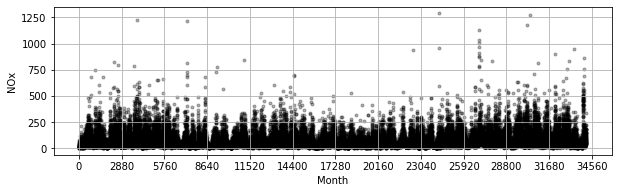

In [67]:
### Data selection(date & NOx)
data = df[df.Date < '20151231']
# data = df
data = data.drop(["Date"], axis=1)
data = data.values
data = data.reshape(len(data),)

fig = plt.figure(figsize = (10, 6))
ax1 = fig.add_subplot(2, 1, 1)
x  = np.arange(len(data))
plt.scatter(x, data, color = 'k', marker = '.', alpha = 0.3)

x_major_locator=MultipleLocator(4*24*30)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlabel('Month')
plt.ylabel('NOx')
plt.grid()

print(data.shape)

(8544,)


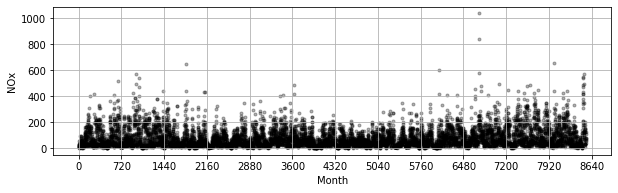

In [68]:
### Average hour data
d1 = data.tolist()
n = len(d1)%4
while n:
  d1.pop()
  n -= 1
m = int(len(d1)/4)
arr = np.array(d1).reshape(m, 4)
avg = np.mean(arr, axis = 1)

fig = plt.figure(figsize = (10, 6))
ax2 = fig.add_subplot(2, 1, 1)
x  = np.arange(len(avg))
plt.scatter(x, avg, color = 'k', marker = '.', alpha = 0.3)

x_major_locator=MultipleLocator(24*30)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlabel('Month')
plt.ylabel('NOx')
plt.grid()

print(avg.shape)

In [69]:
# ### Data normalization
# scaler = MinMaxScaler(feature_range=(0, 1))
# avg = avg.reshape(len(avg), 1)
# data = scaler.fit_transform(avg)
# # data = data.reshape(len(data),)

# data.shape

In [70]:
series = avg
raw_values = series
raw_values.shape

(8544,)

In [71]:
from pandas import Series
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
diff_series = difference(raw_values, 1)
diff_values = diff_series.values
diff_values.shape

(8543,)

In [72]:
diff_values = diff_values.reshape(len(diff_values), 1)
# rescale values to 0, 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(diff_values)
scaled_values = scaled_values.reshape(len(scaled_values), 1)
scaled_values.shape

(8543, 1)

# Build dataset

In [73]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

n_lag = 168
n_out = 72
supervised = series_to_supervised(scaled_values, n_lag, n_out)
supervised.head()

,var1(t-168),var1(t-167),var1(t-166),var1(t-165),var1(t-164),var1(t-163),var1(t-162),var1(t-161),var1(t-160),var1(t-159),var1(t-158),var1(t-157),var1(t-156),var1(t-155),var1(t-154),var1(t-153),var1(t-152),var1(t-151),var1(t-150),var1(t-149),var1(t-148),var1(t-147),var1(t-146),var1(t-145),var1(t-144),var1(t-143),var1(t-142),var1(t-141),var1(t-140),var1(t-139),var1(t-138),var1(t-137),var1(t-136),var1(t-135),var1(t-134),var1(t-133),var1(t-132),var1(t-131),var1(t-130),var1(t-129),...,var1(t+32),var1(t+33),var1(t+34),var1(t+35),var1(t+36),var1(t+37),var1(t+38),var1(t+39),var1(t+40),var1(t+41),var1(t+42),var1(t+43),var1(t+44),var1(t+45),var1(t+46),var1(t+47),var1(t+48),var1(t+49),var1(t+50),var1(t+51),var1(t+52),var1(t+53),var1(t+54),var1(t+55),var1(t+56),var1(t+57),var1(t+58),var1(t+59),var1(t+60),var1(t+61),var1(t+62),var1(t+63),var1(t+64),var1(t+65),var1(t+66),var1(t+67),var1(t+68),var1(t+69),var1(t+70),var1(t+71)
168,0.685833,0.703558,0.715652,0.685820,0.712240,0.702592,0.706767,0.708137,0.707435,0.716375,0.713217,0.708086,0.703255,0.726770,0.730481,0.695735,0.686369,0.720106,0.702064,0.709394,0.693775,0.705131,0.706413,0.711370,0.701345,0.710427,0.709109,0.715921,0.715532,0.764867,0.675123,0.705195,0.716755,0.695690,0.745278,0.689966,0.730253,0.700010,0.701156,0.686995,...,0.715621,0.716585,0.718379,0.668559,0.658820,0.711378,0.694545,0.702551,0.736497,0.676081,0.704165,0.703029,0.711374,0.697609,0.707205,0.703271,0.708669,0.706481,0.714349,0.749627,0.722577,0.676897,0.722388,0.694243,0.688187,0.710179,0.709757,0.779947,0.699381,0.652576,0.710543,0.696672,0.724653,0.720854,0.690748,0.727823,0.683475,0.682354,0.706222,0.704789
169,0.703558,0.715652,0.685820,0.712240,0.702592,0.706767,0.708137,0.707435,0.716375,0.713217,0.708086,0.703255,0.726770,0.730481,0.695735,0.686369,0.720106,0.702064,0.709394,0.693775,0.705131,0.706413,0.711370,0.701345,0.710427,0.709109,0.715921,0.715532,0.764867,0.675123,0.705195,0.716755,0.695690,0.745278,0.689966,0.730253,0.700010,0.701156,0.686995,0.686278,...,0.716585,0.718379,0.668559,0.658820,0.711378,0.694545,0.702551,0.736497,0.676081,0.704165,0.703029,0.711374,0.697609,0.707205,0.703271,0.708669,0.706481,0.714349,0.749627,0.722577,0.676897,0.722388,0.694243,0.688187,0.710179,0.709757,0.779947,0.699381,0.652576,0.710543,0.696672,0.724653,0.720854,0.690748,0.727823,0.683475,0.682354,0.706222,0.704789,0.712035
170,0.715652,0.685820,0.712240,0.702592,0.706767,0.708137,0.707435,0.716375,0.713217,0.708086,0.703255,0.726770,0.730481,0.695735,0.686369,0.720106,0.702064,0.709394,0.693775,0.705131,0.706413,0.711370,0.701345,0.710427,0.709109,0.715921,0.715532,0.764867,0.675123,0.705195,0.716755,0.695690,0.745278,0.689966,0.730253,0.700010,0.701156,0.686995,0.686278,0.706914,...,0.718379,0.668559,0.658820,0.711378,0.694545,0.702551,0.736497,0.676081,0.704165,0.703029,0.711374,0.697609,0.707205,0.703271,0.708669,0.706481,0.714349,0.749627,0.722577,0.676897,0.722388,0.694243,0.688187,0.710179,0.709757,0.779947,0.699381,0.652576,0.710543,0.696672,0.724653,0.720854,0.690748,0.727823,0.683475,0.682354,0.706222,0.704789,0.712035,0.708904
171,0.685820,0.712240,0.702592,0.706767,0.708137,0.707435,0.716375,0.713217,0.708086,0.703255,0.726770,0.730481,0.695735,0.686369,0.720106,0.702064,0.709394,0.693775,0.705131,0.706413,0.711370,0.701345,0.710427,0.709109,0.715921,0.715532,0.764867,0.675123,0.705195,0.716755,0.695690,0.745278,0.689966,0.730253,0.700010,0.701156,0.686995,0.686278,0.706914,0.716921,...,0.668559,0.658820,0.711378,0.694545,0.702551,0.736497,0.676081,0.704165,0.703029,0.711374,0.697609,0.707205,0.703271,0.708669,0.706481,0.714349,0.749627,0.722577,0.676897,0.722388,0.694243,0.688187,0.710179,0.709757,0.779947,0.699381,0.652576,0.710543,0.696672,0.724653,0.720854,0.690748,0.727823,0.683475,0.682354,0.706222,0.704789,0.712035,0.708904,0.703272
172,0.712240,0.702592,0.706767,0.708137,0.707435,0.716375,0.713217,0.708086,0.703255,0.726770,0.730481,0.695735,0.686369,0.720106,0.702064,0.709394,0.693775,0.7051

In [74]:
### Build data set
supervised_values = supervised.values

train = supervised_values[:-n_out-n_lag+1, :]
test = supervised_values[-1:,:]

train_X, train_y = train[:, :-n_out], train[:, -n_out:]
test_X, test_y = test[:, :-n_out], test[:, -n_out:]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8065, 168) (8065, 72) (1, 168) (1, 72)


In [75]:
n_features = 1
train_X = train_X.reshape((train_X.shape[0], n_lag, n_features))
test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))
train_y = train_y.reshape(train_y.shape[0], n_out, n_features)
test_y = test_y.reshape(test_y.shape[0], n_out, n_features)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8065, 168, 1) (8065, 72, 1) (1, 168, 1) (1, 72, 1)


# LSTM Construction & Training

In [76]:
### Configure
lr = 1e-4
n_epochs = 300
batchsize = 128
n_neuron = 150

In [77]:
### Contruct the LSTM
def build_lstm():

  model = Sequential()
  # model.add(LSTM(n_neuron, input_shape=(n_in, n_features)))
  #model.add(LSTM(n_neuron, input_shape=(n_in, n_features), return_sequences=True))
  model.add(LSTM(n_neuron, input_shape=(n_lag, n_features), return_sequences=True))
  model.add(LSTM(100, return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(n_out))
  #model.add(Activation("sigmoid"))
  model.compile(optimizer=adam_v2.Adam(learning_rate=lr), loss='mae')

  return model

Epoch 1/300
64/64 [==============================] - 9s 91ms/step - loss: 0.5434 - val_loss: 0.2512
Epoch 2/300
64/64 [==============================] - 5s 76ms/step - loss: 0.2263 - val_loss: 0.0857
Epoch 3/300
64/64 [==============================] - 5s 76ms/step - loss: 0.1684 - val_loss: 0.0704
Epoch 4/300
64/64 [==============================] - 5s 76ms/step - loss: 0.1455 - val_loss: 0.0508
Epoch 5/300
64/64 [==============================] - 5s 76ms/step - loss: 0.1313 - val_loss: 0.0499
Epoch 6/300
64/64 [==============================] - 5s 76ms/step - loss: 0.1207 - val_loss: 0.0635
Epoch 7/300
64/64 [==============================] - 5s 76ms/step - loss: 0.1126 - val_loss: 0.0483
Epoch 8/300
64/64 [==============================] - 5s 76ms/step - loss: 0.1052 - val_loss: 0.0440
Epoch 9/300
64/64 [==============================] - 5s 76ms/step - loss: 0.0996 - val_loss: 0.0493
Epoch 10/300
64/64 [==============================] - 5s 76ms/step - loss: 0.0952 - val_loss: 0.0358

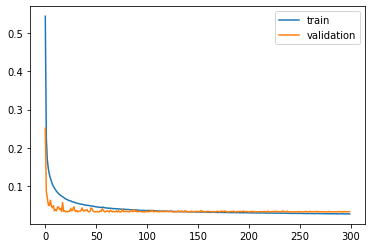

In [78]:
### Training LSTM
def model_fit(x_train, y_train, x_val, y_val):
    
    model = build_lstm()

    my_callbacks = [ModelCheckpoint(filepath='my_model.h5', save_best_only=True)]
    # my_callbacks = [EarlyStopping(patience=100), ModelCheckpoint(filepath='my_model.h5', save_best_only=True), ReduceLROnPlateau(factor = 0.1, patience = 50)]
    history = model.fit(x_train, y_train, batch_size=batchsize, epochs=n_epochs, verbose=1, callbacks=my_callbacks, validation_data=(x_val, y_val))
    # history = model.fit(x_train, y_train, batch_size=batchsize, epochs=n_epochs, verbose=1, validation_data=(x_val, y_val))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.show()
    
    return model

model = model_fit(train_X, train_y, test_X, test_y)
#model = model_fit(x_train, y_train, x_val, y_val)
model = load_model('my_model.h5')

# Results visualization & Analysis

In [79]:
# make a prediction
forecasts = model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], n_lag*n_features))
# # invert scaling for forecast
# inv_yhat = np.concatenate((yhat, test_X[:, -8:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = scaler.inverse_transform(forecasts)
inv_yhat = inv_yhat.reshape(inv_yhat.shape[1], inv_yhat.shape[0])

In [80]:
Prediction = np.zeros(n_out)
Prediction[0] = raw_values[-n_out-1]+inv_yhat[0]
for i in range(1, inv_yhat.size):
  Prediction[i] = Prediction[i-1]+inv_yhat[i]
Prediction

array([13.36883545, 13.11956787, 11.92072678, 12.62730217,  9.47650337,
       10.32939243, 11.42843628, 14.04279709, 17.2913208 , 19.84652901,
       18.19028473, 16.63241959, 18.13375473, 20.75807953, 22.12327385,
       20.83155823, 22.08903885, 20.11397171, 19.93820953, 23.10814285,
       24.19959259, 25.56053734, 25.98382187, 28.51959229, 28.12359238,
       29.4768734 , 31.23781013, 33.14422226, 31.99394417, 36.70775986,
       38.8313446 , 37.83483505, 37.85750198, 35.49853516, 38.21594238,
       37.67237473, 36.47053909, 35.36889267, 40.04020691, 43.26838684,
       42.36001205, 46.32658768, 46.78059769, 47.01457977, 47.9353981 ,
       47.56120682, 47.30594635, 46.94687271, 45.34671402, 45.70332336,
       46.46535873, 48.18038177, 50.44679642, 52.23100281, 53.31694794,
       53.26158142, 54.1458931 , 55.69035721, 56.26664352, 55.33485794,
       54.30274582, 54.37244034, 56.82850266, 60.39731216, 62.81679916,
       62.67043686, 64.68818665, 64.44630432, 66.43660736, 66.62

In [81]:
Truth = raw_values[-72:]
Truth

array([  7.6901175,   8.1181675,   5.48346  ,   6.405815 ,   4.4023675,
        11.135275 ,  17.80448  ,  33.87635  ,  83.732875 , 119.201325 ,
       138.60775  ,  99.1055   , 115.478875 , 126.88445  , 194.463    ,
       357.43125  , 435.1195   , 540.638    , 543.827    , 468.35675  ,
       486.571    , 415.25525  , 380.208    , 419.64725  , 342.8475   ,
       311.996    , 207.5675   , 210.7835   , 165.77275  , 177.345    ,
       182.47875  , 491.9425   , 568.01025  , 345.4155   , 132.51685  ,
       115.94475  , 114.54185  ,  90.679775 ,  73.62065  , 102.203975 ,
       125.3891   , 130.73925  , 122.2172   ,  87.776975 ,  71.46355  ,
        44.599625 ,  68.06355  ,  35.097775 ,  32.51025  ,  30.2664   ,
        25.0784   ,  37.2461   ,  13.79598  ,  33.5657   ,  68.09405  ,
       129.4685   ,  82.776125 , 126.11985  , 140.0889   , 157.64375  ,
       202.07475  , 147.51325  , 145.50335  , 178.624    , 124.680825 ,
       107.777375 ,  83.3944   ,  82.2444   ,  67.588225 ,  72.7

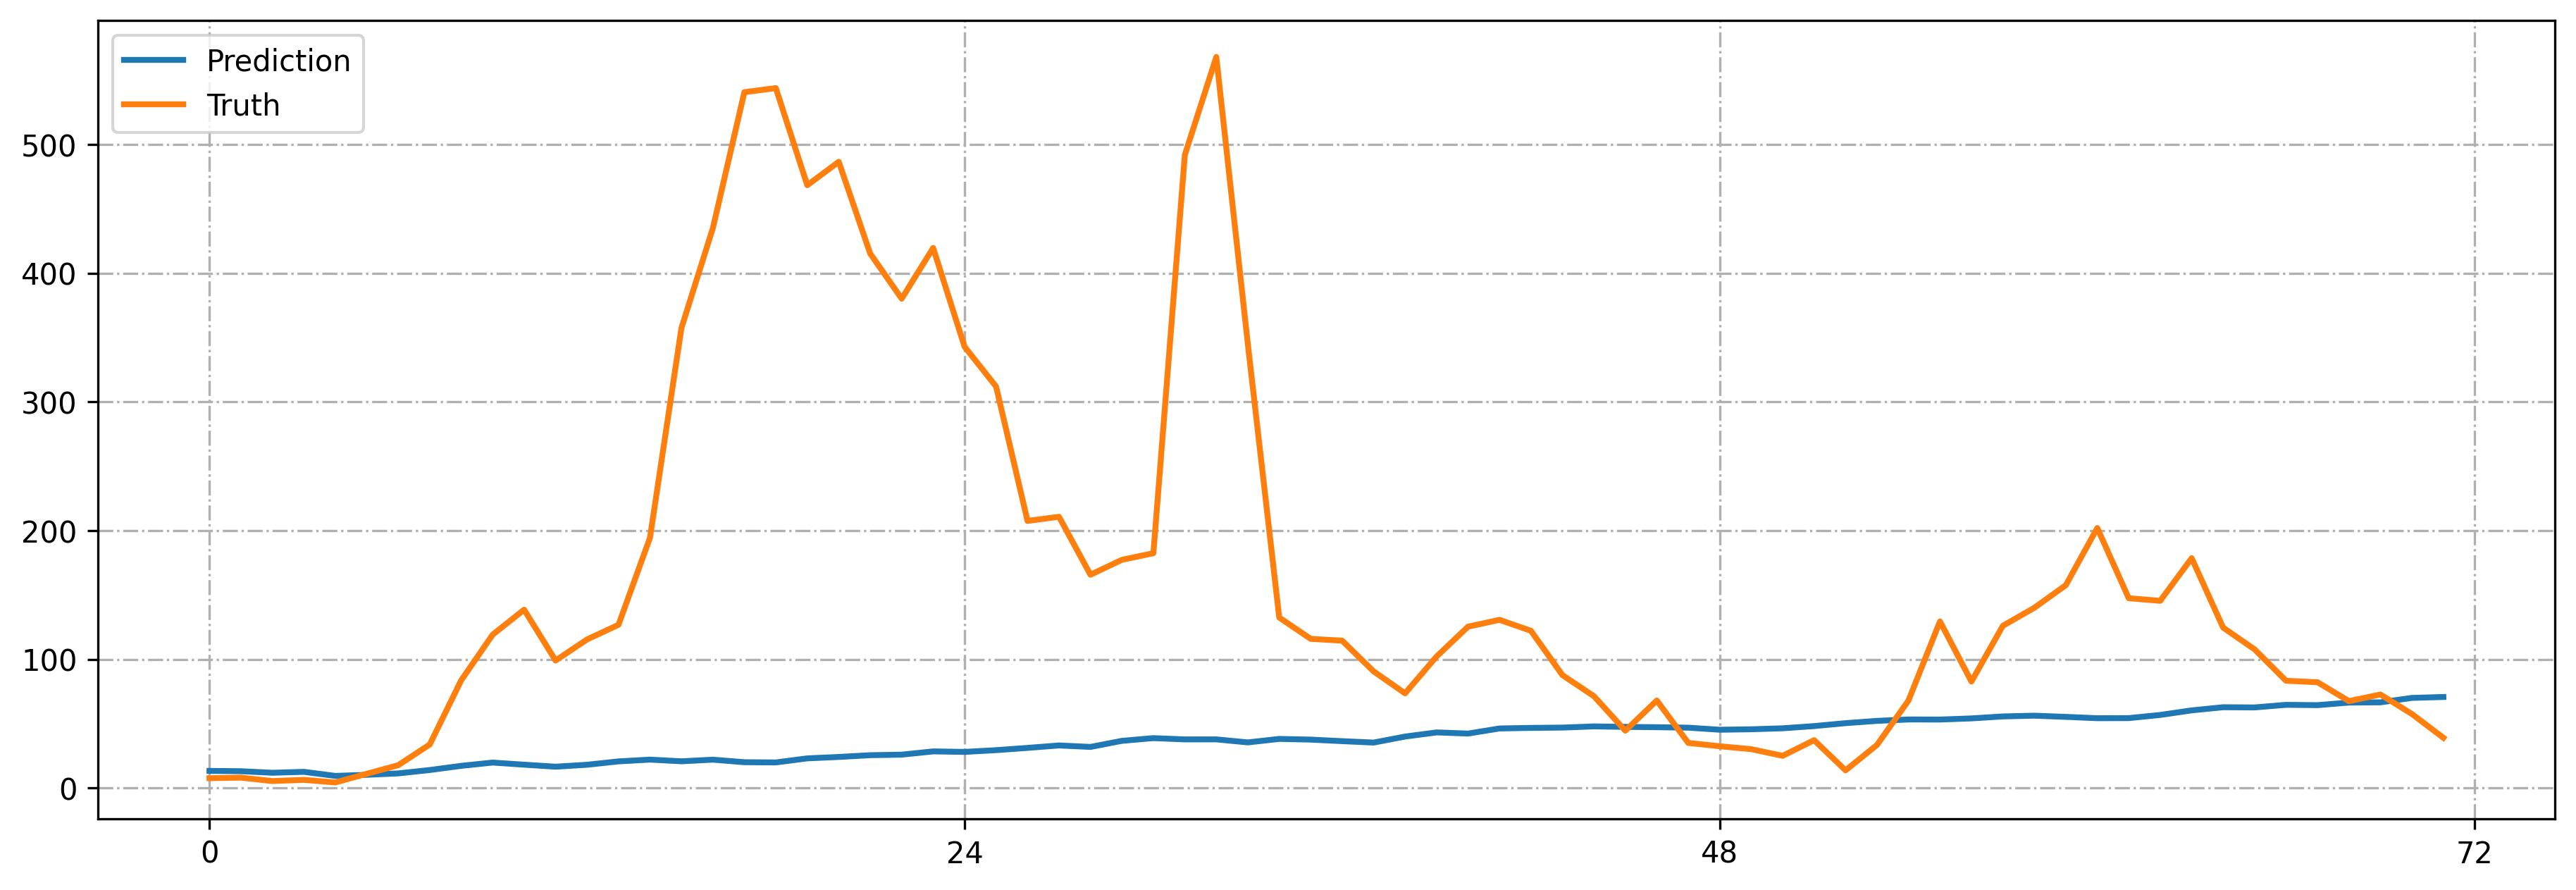

In [82]:
### Visualization
x = [x for x in range(n_out)]
fig, ax = plt.subplots(figsize=(15,5), dpi = 300)
ax.plot(x, Prediction, linewidth=2.0, label = "Prediction")
ax.plot(x, Truth, linewidth=2.0, label = "Truth")

x_major_locator=MultipleLocator(24)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)

ax.legend(loc=2);
plt.grid(linestyle='-.')
plt.show()

In [83]:
### Analysis
MSE = mean_squared_error(Truth, Prediction)
RMSE = np.sqrt(MSE) #均方根误差
print('RMSE: %.3f' %RMSE)
MAE = mean_absolute_error(Truth, Prediction) #平均绝对误差
print('MAE: %.3f' %MAE)
MAPE = np.mean(np.abs((Truth - Prediction) / Truth)) * 100 #平均绝对百分比误差
print('MAPE: %.3f' %MAPE)
MedAE = median_absolute_error(Truth, Prediction) #中位数绝对误差
print('MedAE: %.3f' %MedAE)
r2_score = r2_score(Truth, Prediction) #决定系数
print('r2_score: %.3f' %r2_score)
explained_variance_score = explained_variance_score(Truth, Prediction) #解释方差分（衡量模型对数据集波动的解释程度，如果取值为1时，模型就完美，越小效果就越差）
print('explained_variance_score: %.3f' %explained_variance_score)

RMSE: 196.665
MAE: 127.446
MAPE: 68.356
MedAE: 77.139
r2_score: -0.730
explained_variance_score: -0.067
